# Analyse des données météo brutes MongoDB

Ce notebook analyse les données météo brutes stockées dans MongoDB et crée des visualisations pour comprendre la distribution des données et les tendances météorologiques.

## 1. Configuration

Importer les bibliothèques requises et se connecter à MongoDB.

In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

load_dotenv()

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
MONGO_USER = os.getenv("MONGO_INITDB_ROOT_USERNAME", "admin")
MONGO_PASSWORD = os.getenv("MONGO_INITDB_ROOT_PASSWORD", "admin")
MONGO_HOST = "localhost"
MONGO_PORT = os.getenv("MONGO_PORT", "27017")
MONGO_DB = os.getenv("MONGO_DB", "weather")
MONGO_COLLECTION = "raw_weather"

MONGO_URI = f"mongodb://{MONGO_USER}:{MONGO_PASSWORD}@{MONGO_HOST}:{MONGO_PORT}/?authSource=admin"

client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=5000)
client.admin.command('ping')
print("Connected to MongoDB successfully!")

db = client[MONGO_DB]
collection = db[MONGO_COLLECTION]

total_docs = collection.count_documents({})
print(f"Total documents in collection: {total_docs}")

Connected to MongoDB successfully!
Total documents in collection: 839


In [3]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

rows = []
for _, doc in df.iterrows():
    city = doc['city']
    doc_timestamp = doc['timestamp']
    hourly = doc['data'].get('hourly', {})
    times = hourly.get('time', [])

    for i, time in enumerate(times):
        rows.append({
            'city': city,
            'doc_timestamp': doc_timestamp,
            'timestamp': time,
            'temperature': hourly.get('temperature_2m', [None]*len(times))[i],
            'precipitation': hourly.get('precipitation', [None]*len(times))[i],
            'humidity': hourly.get('relative_humidity_2m', [None]*len(times))[i],
            'wind_speed': hourly.get('wind_speed_10m', [None]*len(times))[i]
        })

df_flat = pd.DataFrame(rows)
df_flat['timestamp'] = pd.to_datetime(df_flat['timestamp'])

print(f"\nFlattened DataFrame shape: {df_flat.shape}")
print(f"Flattened columns: {df_flat.columns.tolist()}")
df_flat.head()

DataFrame shape: (845, 9)

Columns: ['_id', 'city', 'latitude', 'longitude', 'timestamp', 'ingestion_timestamp', 'execution_date', 'dag_run_id', 'data']

Flattened DataFrame shape: (141960, 7)
Flattened columns: ['city', 'doc_timestamp', 'timestamp', 'temperature', 'precipitation', 'humidity', 'wind_speed']


,city,doc_timestamp,timestamp,temperature,precipitation,humidity,wind_speed
0,Toulouse,2026-02-06 09:23:53.799,2026-02-06 00:00:00,8.4,0.1,89,7.1
1,Toulouse,2026-02-06 09:23:53.799,2026-02-06 01:00:00,8.9,0.0,86,7.0
2,Toulouse,2026-02-06 09:23:53.799,2026-02-06 02:00:00,9.2,0.2,84,7.6
3,Toulouse,2026-02-06 09:23:53.799,2026-02-06 03:00:00,10.0,0.4,83,6.8
4,Toulouse,2026-02-06 09:23:53.799,2026-02-06 04:00:00,8.1,0.0,92,4.4


## 2. Visualisations

### 2.1 Diagramme en barres - Documents par ville

Affiche la distribution du volume de données entre les différentes villes.

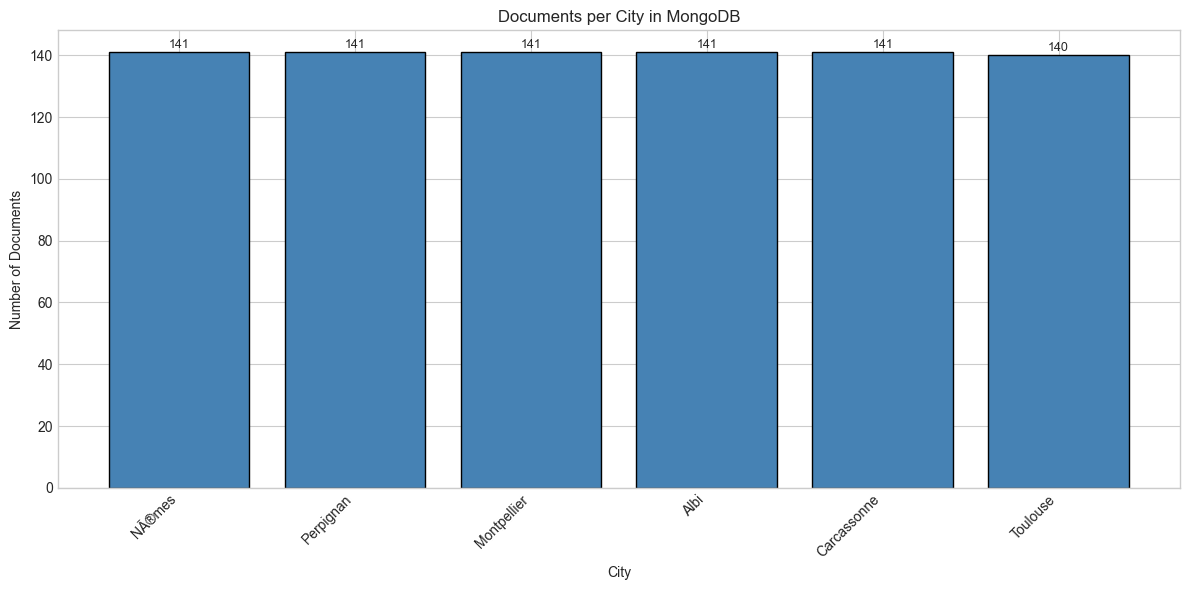


Total cities: 6
Total documents: 845


In [4]:
pipeline = [
    {"$group": {"_id": "$city", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]
city_counts = list(collection.aggregate(pipeline))
city_df = pd.DataFrame(city_counts)
city_df.columns = ['city', 'count']

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(city_df['city'], city_df['count'], color='steelblue', edgecolor='black')
ax.set_xlabel('City')
ax.set_ylabel('Number of Documents')
ax.set_title('Documents per City in MongoDB')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, city_df['count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTotal cities: {len(city_df)}")
print(f"Total documents: {city_df['count'].sum()}")

### 2.2 Graphique linéaire - Température par ville au fil du temps

Affiche les tendances de température pour chaque ville.

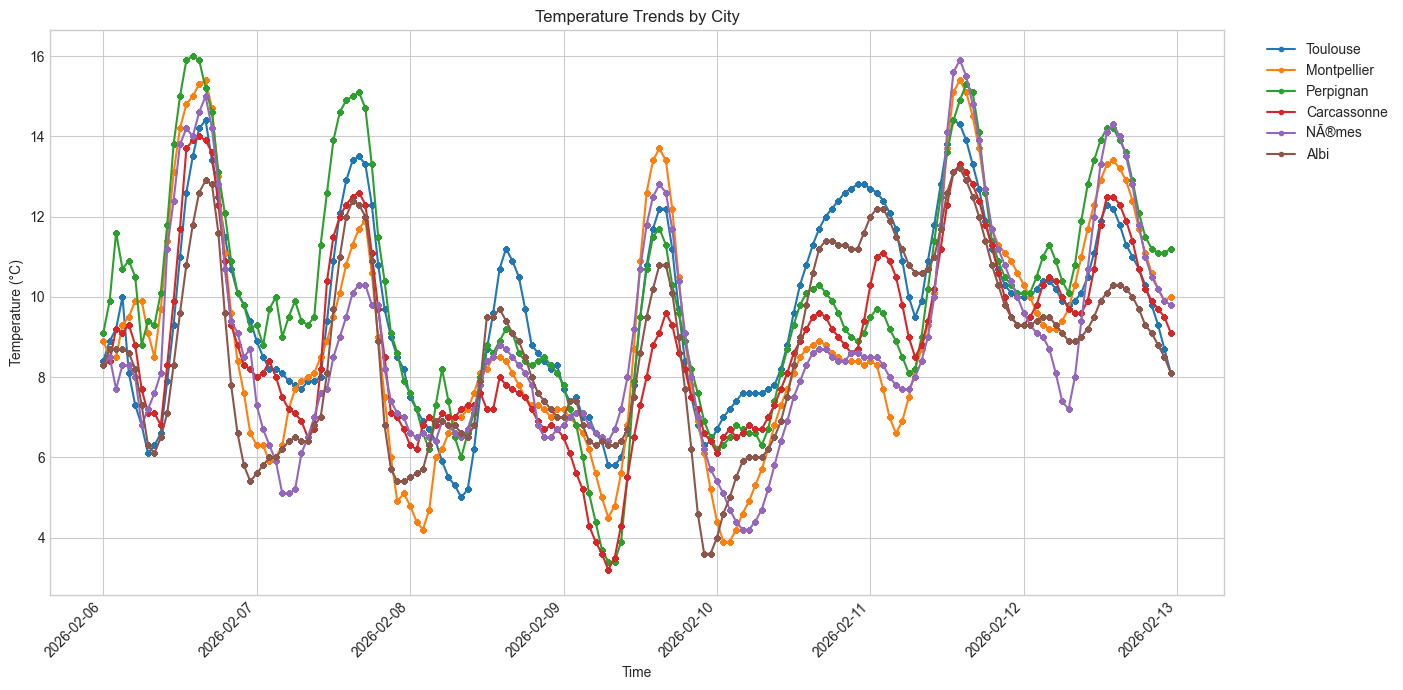

In [5]:
fig, ax = plt.subplots(figsize=(14, 7))

for city in df_flat['city'].unique():
    city_data = df_flat[df_flat['city'] == city].sort_values('timestamp')
    ax.plot(city_data['timestamp'], city_data['temperature'], 
            marker='o', markersize=3, label=city, linewidth=1.5)

ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature Trends by City')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.3 Histogramme - Distribution des précipitations

Affiche la distribution de fréquence des valeurs de précipitations.

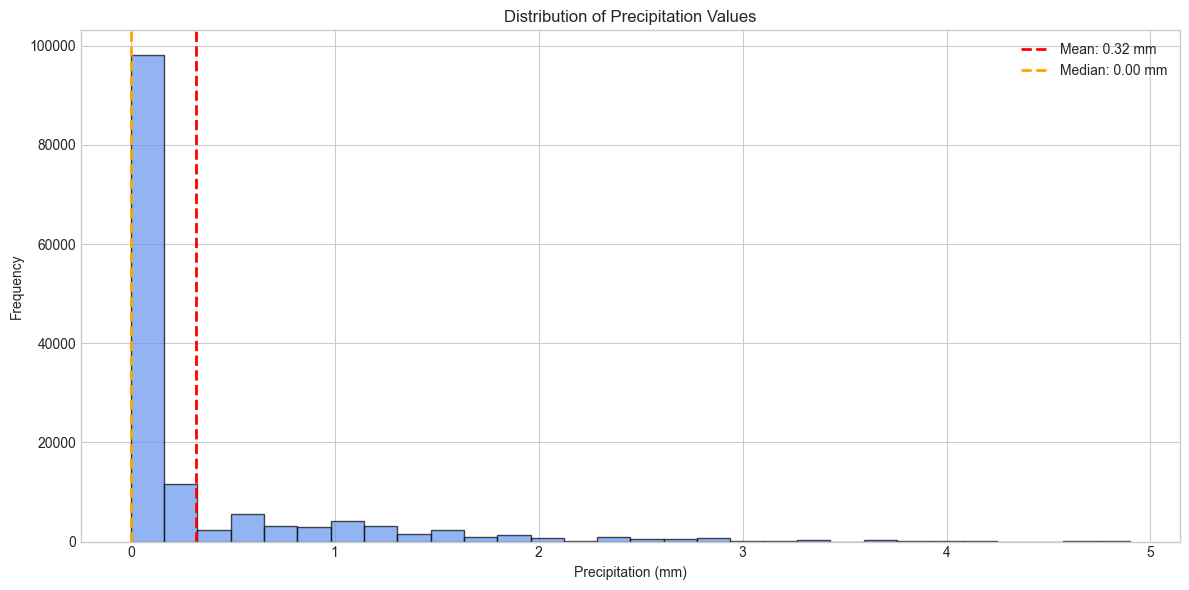


Precipitation Statistics:
  Min: 0.00 mm
  Max: 4.90 mm
  Mean: 0.32 mm
  Std Dev: 0.66 mm


In [6]:
precip_data = df_flat['precipitation'].dropna()

fig, ax = plt.subplots(figsize=(12, 6))
n, bins, patches = ax.hist(precip_data, bins=30, color='cornflowerblue', 
                            edgecolor='black', alpha=0.7)

ax.axvline(precip_data.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {precip_data.mean():.2f} mm')
ax.axvline(precip_data.median(), color='orange', linestyle='--', 
           linewidth=2, label=f'Median: {precip_data.median():.2f} mm')

ax.set_xlabel('Precipitation (mm)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Precipitation Values')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nPrecipitation Statistics:")
print(f"  Min: {precip_data.min():.2f} mm")
print(f"  Max: {precip_data.max():.2f} mm")
print(f"  Mean: {precip_data.mean():.2f} mm")
print(f"  Std Dev: {precip_data.std():.2f} mm")

### 2.4 Boîte à moustaches - Comparaison des métriques météo

Compare la distribution de la température, l'humidité et la vitesse du vent entre les villes.

C:\Users\terra\AppData\Local\Temp\ipykernel_19220\2083677280.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_city, labels=cities, patch_artist=True)
C:\Users\terra\AppData\Local\Temp\ipykernel_19220\2083677280.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_city, labels=cities, patch_artist=True)
C:\Users\terra\AppData\Local\Temp\ipykernel_19220\2083677280.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_city, labels=cities, patch_artist=True)


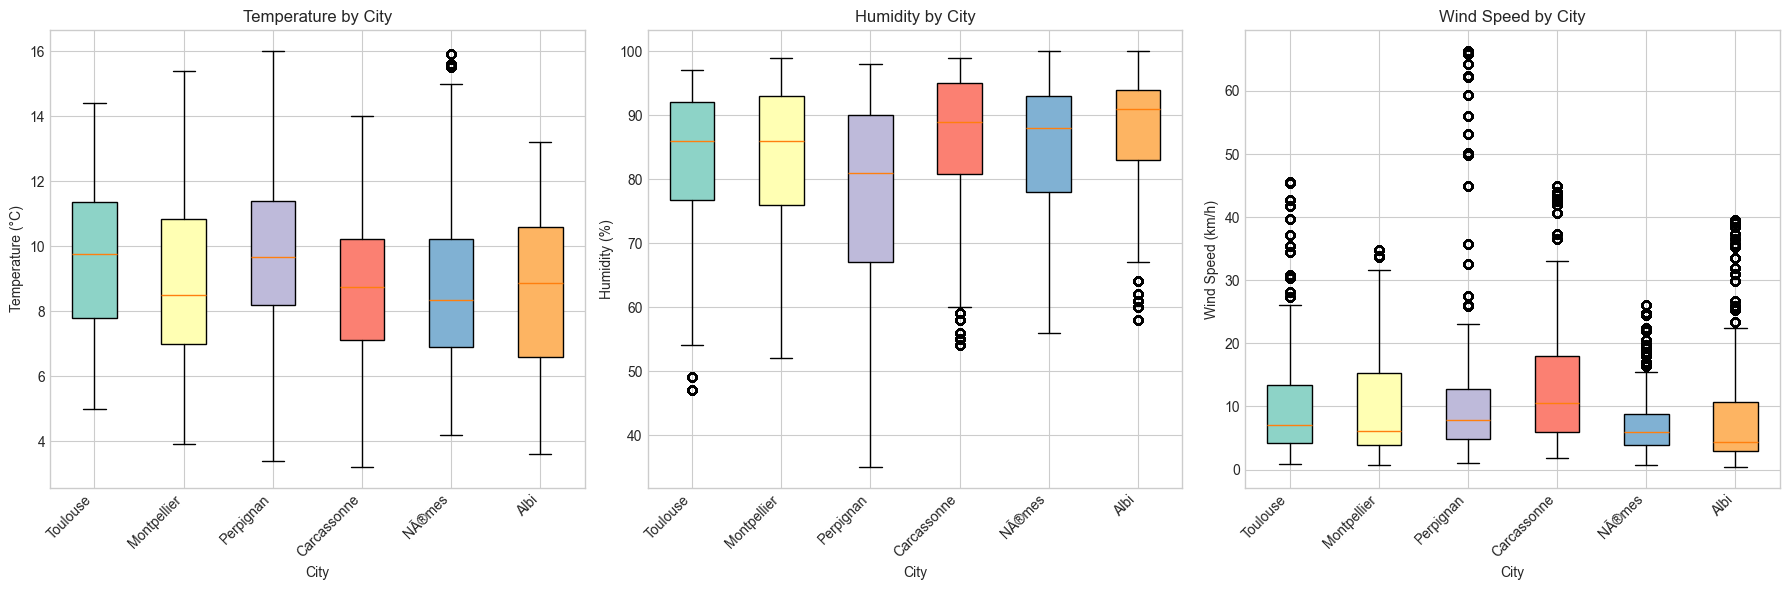

In [7]:
metrics = ['temperature', 'humidity', 'wind_speed']
metric_labels = ['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cities = df_flat['city'].unique()
colors = plt.cm.Set3(range(len(cities)))

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx]
    
    data_by_city = [df_flat[df_flat['city'] == city][metric].dropna() for city in cities]
    
    bp = ax.boxplot(data_by_city, labels=cities, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xlabel('City')
    ax.set_ylabel(label)
    ax.set_title(f'{label.split(" (")[0]} by City')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 3. Nettoyage

In [8]:
client.close()
print("MongoDB connection closed.")

MongoDB connection closed.
